**Challenge: Implement a Multiclass Classification Neural Network using PyTorch**

Objective:
Build a neural network using PyTorch to predict handwritten digits of MNIST.

Steps:

1. **Data Preparation**: Load the MNIST dataset using ```torchvision.datasets.MNIST```. Standardize/normalize the features. Split the dataset into training and testing sets using, for example, ```sklearn.model_selection.train_test_split()```. **Bonus scores**: *use PyTorch's built-* ```DataLoader``` *to split the dataset*.

2. **Neural Network Architecture**: Define a simple feedforward neural network using PyTorch's ```nn.Module```. Design the input layer to match the number of features in the MNIST dataset and the output layer to have as many neurons as there are classes (10). You can experiment with the number of hidden layers and neurons to optimize the performance. **Bonus scores**: *Make your architecture flexibile to have as many hidden layers as the user wants, and use hyperparameter optimization to select the best number of hidden layeres.*

3. **Loss Function and Optimizer**: Choose an appropriate loss function for multiclass classification. Select an optimizer, like SGD (Stochastic Gradient Descent) or Adam.

4. **Training**: Write a training loop to iterate over the dataset.
Forward pass the input through the network, calculate the loss, and perform backpropagation. Update the weights of the network using the chosen optimizer.

5. **Testing**: Evaluate the trained model on the test set. Calculate the accuracy of the model.

6. **Optimization**: Experiment with hyperparameters (learning rate, number of epochs, etc.) to optimize the model's performance. Consider adjusting the neural network architecture for better results. **Notice that you can't use the optimization algorithms from scikit-learn that we saw in lab1: e.g.,** ```GridSearchCV```.


In [435]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision as tv

# Data preparation

## Loading and normalization

In [437]:
# The Normalize transform needs the mean and std of the dataset, but we need to load it first to
# be able to calculate it. It will be modified later with the correct values.
transforms = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize(0, 0)])

train_set = tv.datasets.MNIST(root="./data", train=True, download=True, transform=transforms)
test_set = tv.datasets.MNIST(root="./data", train=False, download=True, transform=transforms)

## Normalization

In [438]:
def calc_mean_std(tensor):
    mean = tensor.float().mean().item()
    std = tensor.float().std().item()
    return mean, std

mean, std = calc_mean_std(train_set.data)
mean, std

(33.31842041015625, 78.56748962402344)

In [439]:
# ToTensor maps the pixel range [0, 255] to tensor range [0, 1]
# The mean and std were calculated from the images so they have to be adjusted

mean_after_tensor = mean / 255
std_after_tensor = std / 255

mean_after_tensor, std_after_tensor

(0.13066047219669116, 0.30810780244715075)

In [440]:
transforms.transforms[-1].mean = mean_after_tensor
transforms.transforms[-1].std = std_after_tensor

## Splitting

In [441]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True, drop_last=True)

# Neural network architecture

In [442]:
# Number of features after flattening
feats = np.prod(train_set.data.shape[1:])
feats

784

In [443]:
classes = len(train_set.classes)
classes

10

In [444]:
class Net(nn.Module):

    def __init__(self, hidden_layers, hidden_neurons, dropout_rate):
        super().__init__()

        self.flatten = nn.Flatten()
        self.input = nn.Linear(feats, hidden_neurons)
        self.act_input = nn.ReLU()

        hidden = []
        for _ in range(hidden_layers):
            hidden.append(nn.Linear(hidden_neurons, hidden_neurons))
            hidden.append(nn.ReLU())
            hidden.append(nn.Dropout(dropout_rate))

        self.hidden = nn.Sequential(*hidden)

        self.output = nn.Linear(hidden_neurons, classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x


In [445]:
# We will try without dropout layers first
model = Net(2, 128, 0)

# Loss function and optimizer

Since we are dealing with a non-binary classification problem, the best choice for a loss function is Cross Entropy.

In [446]:
loss_fn = nn.CrossEntropyLoss()

For the optimizer, we will try SDG first but of course we will test other optimizers in the optimization section.

In [447]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and testing

In [448]:
def train(n_epochs, model, optimizer):
    for epoch in range(n_epochs):
        losses = []

        # Update params
        model.train()
        tp = 0
        for inputs, labels in train_loader:
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tp += (pred.argmax(1) == labels).float().sum()

        acc_train = tp / len(train_loader.dataset)

        # Evaluate epoch
        model.eval()
        tp = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                pred = model(inputs)

                tp += (pred.argmax(1) == labels).float().sum()

        acc_test = tp / len(test_loader.dataset)


        print(
            f"Epoch {epoch + 1} | " +
            f"Acc: Train {acc_train * 100:.2f}% Test {acc_test * 100:.2f}% | " +
            f"Avg Loss: {np.mean(losses):.4f} Min Loss: {np.min(losses):.4f}"
        )



In [449]:
train(20, model, optimizer)

Epoch 1 | Acc: Train 89.31% Test 94.77% | Avg Loss: 0.3647 Min Loss: 0.0289
Epoch 2 | Acc: Train 95.79% Test 95.95% | Avg Loss: 0.1355 Min Loss: 0.0134
Epoch 3 | Acc: Train 97.01% Test 96.66% | Avg Loss: 0.0956 Min Loss: 0.0058
Epoch 4 | Acc: Train 97.56% Test 96.80% | Avg Loss: 0.0763 Min Loss: 0.0034
Epoch 5 | Acc: Train 98.00% Test 97.12% | Avg Loss: 0.0636 Min Loss: 0.0016
Epoch 6 | Acc: Train 98.18% Test 97.43% | Avg Loss: 0.0534 Min Loss: 0.0017
Epoch 7 | Acc: Train 98.49% Test 97.00% | Avg Loss: 0.0457 Min Loss: 0.0017
Epoch 8 | Acc: Train 98.64% Test 97.21% | Avg Loss: 0.0391 Min Loss: 0.0007
Epoch 9 | Acc: Train 98.76% Test 97.53% | Avg Loss: 0.0351 Min Loss: 0.0006
Epoch 10 | Acc: Train 98.93% Test 97.66% | Avg Loss: 0.0309 Min Loss: 0.0003
Epoch 11 | Acc: Train 99.09% Test 97.56% | Avg Loss: 0.0260 Min Loss: 0.0002
Epoch 12 | Acc: Train 99.05% Test 97.71% | Avg Loss: 0.0256 Min Loss: 0.0003
Epoch 13 | Acc: Train 99.25% Test 97.54% | Avg Loss: 0.0206 Min Loss: 0.0002
Epoch 14

# Optimization

## Dropout and learning rate

First, we can see that the model is slightly overfitting, as the accuracy on the test set pleateaus at around $97\%-98\%$ but on the train set it continues going up until $99.60\%$ (it would be more if we further increased the epochs). Let's see what happens when we use the dropout layers that, already getting ahead of the problem, we added before.

The original model starts to overfit around epoch $3$, with a test accuracy of around $96\%$. *Early stopping* would be a good technique to avoid overfitting here, as that accuracy is alredy quite high, but maybe we can do better. We will use that as a reference point for the following optimizations.

In [460]:
model = Net(2, 128, 0.3)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(50, model, optimizer)

Epoch 1 | Acc: Train 83.76% Test 93.68% | Avg Loss: 0.5237 Min Loss: 0.0703
Epoch 2 | Acc: Train 92.12% Test 94.95% | Avg Loss: 0.2651 Min Loss: 0.0529
Epoch 3 | Acc: Train 93.46% Test 95.92% | Avg Loss: 0.2216 Min Loss: 0.0158
Epoch 4 | Acc: Train 94.06% Test 95.98% | Avg Loss: 0.1974 Min Loss: 0.0323
Epoch 5 | Acc: Train 94.52% Test 96.55% | Avg Loss: 0.1863 Min Loss: 0.0238
Epoch 6 | Acc: Train 94.95% Test 96.52% | Avg Loss: 0.1675 Min Loss: 0.0220
Epoch 7 | Acc: Train 95.17% Test 96.72% | Avg Loss: 0.1615 Min Loss: 0.0173
Epoch 8 | Acc: Train 95.53% Test 97.09% | Avg Loss: 0.1536 Min Loss: 0.0121
Epoch 9 | Acc: Train 95.40% Test 96.69% | Avg Loss: 0.1540 Min Loss: 0.0134
Epoch 10 | Acc: Train 95.56% Test 96.84% | Avg Loss: 0.1431 Min Loss: 0.0064
Epoch 11 | Acc: Train 95.78% Test 96.49% | Avg Loss: 0.1399 Min Loss: 0.0112
Epoch 12 | Acc: Train 95.90% Test 96.68% | Avg Loss: 0.1370 Min Loss: 0.0075
Epoch 13 | Acc: Train 95.90% Test 97.24% | Avg Loss: 0.1351 Min Loss: 0.0103
Epoch 14

After testing several dropout rates, also adjusting the learning rate and epochs to account for the extra slowness in training that comes with dropout, a rate of $0.3$ is what seems optimal. We won't show the output for each test to avoid cluttering the notebook, but these were the most remarkable results:

- With $0.5$ and $0.4$, using $lr=0.01$, accuracy started to plateau around $97\%$, which is better than before but we wanted to see if it could do better.
- With $0.3$ , using $lr=0.01$, accuracy went up to $97.5\%$, even going up to $98\%$ in some runs.
- With $0.2$, it started overfitting again after around $12$ epochs.

## Optimizer

Let's try with **Adam**.

In [468]:
model = Net(1, 128, 0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(50, model, optimizer)

Epoch 1 | Acc: Train 90.34% Test 95.16% | Avg Loss: 0.3194 Min Loss: 0.0314
Epoch 2 | Acc: Train 94.40% Test 96.05% | Avg Loss: 0.1825 Min Loss: 0.0210
Epoch 3 | Acc: Train 95.31% Test 96.57% | Avg Loss: 0.1523 Min Loss: 0.0083
Epoch 4 | Acc: Train 95.74% Test 96.79% | Avg Loss: 0.1368 Min Loss: 0.0155
Epoch 5 | Acc: Train 96.04% Test 96.52% | Avg Loss: 0.1278 Min Loss: 0.0105
Epoch 6 | Acc: Train 96.34% Test 97.01% | Avg Loss: 0.1170 Min Loss: 0.0049
Epoch 7 | Acc: Train 96.58% Test 96.87% | Avg Loss: 0.1101 Min Loss: 0.0051
Epoch 8 | Acc: Train 96.48% Test 97.31% | Avg Loss: 0.1107 Min Loss: 0.0052
Epoch 9 | Acc: Train 96.69% Test 97.24% | Avg Loss: 0.1054 Min Loss: 0.0052
Epoch 10 | Acc: Train 96.78% Test 96.88% | Avg Loss: 0.1007 Min Loss: 0.0029
Epoch 11 | Acc: Train 96.85% Test 97.05% | Avg Loss: 0.1006 Min Loss: 0.0033
Epoch 12 | Acc: Train 96.93% Test 97.16% | Avg Loss: 0.0958 Min Loss: 0.0038
Epoch 13 | Acc: Train 96.91% Test 97.39% | Avg Loss: 0.0991 Min Loss: 0.0025
Epoch 14

Since Adam doesn't have momentum, it's more likely that the gradient explodes in later epochs with a big learning rate.

- $lr=0.01$ caused the gradients to explode, as expected, and accuracy decreased continuously.
- $lr=0.001$ yielded slightly worse results than **SGD** in the previous section.

## Number of hidden layers

It is important to watch out for overfitting as it is a known effect of incresing the depth of neural networks.

In [463]:
model = Net(1, 128, 0.3)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(50, model, optimizer)

Epoch 1 | Acc: Train 89.14% Test 94.56% | Avg Loss: 0.3583 Min Loss: 0.0571
Epoch 2 | Acc: Train 94.56% Test 96.24% | Avg Loss: 0.1813 Min Loss: 0.0263
Epoch 3 | Acc: Train 95.47% Test 96.76% | Avg Loss: 0.1497 Min Loss: 0.0119
Epoch 4 | Acc: Train 96.07% Test 96.65% | Avg Loss: 0.1302 Min Loss: 0.0089
Epoch 5 | Acc: Train 96.32% Test 97.16% | Avg Loss: 0.1180 Min Loss: 0.0078
Epoch 6 | Acc: Train 96.62% Test 97.29% | Avg Loss: 0.1107 Min Loss: 0.0051
Epoch 7 | Acc: Train 96.65% Test 97.15% | Avg Loss: 0.1053 Min Loss: 0.0079
Epoch 8 | Acc: Train 96.97% Test 97.22% | Avg Loss: 0.0979 Min Loss: 0.0034
Epoch 9 | Acc: Train 96.83% Test 97.47% | Avg Loss: 0.0965 Min Loss: 0.0063
Epoch 10 | Acc: Train 97.08% Test 97.43% | Avg Loss: 0.0900 Min Loss: 0.0060
Epoch 11 | Acc: Train 97.18% Test 97.44% | Avg Loss: 0.0872 Min Loss: 0.0032
Epoch 12 | Acc: Train 97.25% Test 97.46% | Avg Loss: 0.0846 Min Loss: 0.0030
Epoch 13 | Acc: Train 97.31% Test 97.33% | Avg Loss: 0.0821 Min Loss: 0.0023
Epoch 14

- Neither $4$ nor $6$ layers improved accuracy.
- Decreasing the number of layers to $1$ also maintained accuracy so by occam's razor, we will choose this number of layers.

Decreasing the number of layers to 0 would cause the model to underfit as it gives it essentially no capacity to abstract and generalize.

## Number of neurons per hidden layer

In [465]:
model = Net(1, 256, 0.3)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(50, model, optimizer)

Epoch 1 | Acc: Train 90.30% Test 94.85% | Avg Loss: 0.3253 Min Loss: 0.0454
Epoch 2 | Acc: Train 95.31% Test 96.47% | Avg Loss: 0.1548 Min Loss: 0.0180
Epoch 3 | Acc: Train 96.40% Test 96.94% | Avg Loss: 0.1174 Min Loss: 0.0078
Epoch 4 | Acc: Train 96.89% Test 97.23% | Avg Loss: 0.0993 Min Loss: 0.0056
Epoch 5 | Acc: Train 97.24% Test 97.35% | Avg Loss: 0.0860 Min Loss: 0.0054
Epoch 6 | Acc: Train 97.50% Test 97.47% | Avg Loss: 0.0780 Min Loss: 0.0032
Epoch 7 | Acc: Train 97.63% Test 97.68% | Avg Loss: 0.0710 Min Loss: 0.0026
Epoch 8 | Acc: Train 97.77% Test 97.46% | Avg Loss: 0.0686 Min Loss: 0.0030
Epoch 9 | Acc: Train 97.88% Test 97.80% | Avg Loss: 0.0625 Min Loss: 0.0026
Epoch 10 | Acc: Train 98.11% Test 97.87% | Avg Loss: 0.0568 Min Loss: 0.0025
Epoch 11 | Acc: Train 98.14% Test 97.82% | Avg Loss: 0.0543 Min Loss: 0.0009
Epoch 12 | Acc: Train 98.31% Test 97.75% | Avg Loss: 0.0510 Min Loss: 0.0014
Epoch 13 | Acc: Train 98.37% Test 97.86% | Avg Loss: 0.0478 Min Loss: 0.0011
Epoch 14

- $64$ neurons per layer made the model underfit.
- $256$ overfitted.

Thus, we stay with our choice of $128$ neurons per layer.

## CNN

Taking a more drastic approach regarding network architecture, let's consider the following: With MNIST being an image dataset, why not just use a CNN?

In [509]:
class ConvNet(nn.Module):

    def __init__(self, hidden_neurons, dropout_rate):
        super().__init__()

        self.conv = nn.Sequential(
            nn.LazyConv2d(32, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.LazyConv2d(32, 3),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.LazyLinear(hidden_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.LazyLinear(classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [511]:
cnn = ConvNet(128, 0.5)
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
train(20, cnn, optimizer)

Epoch 1 | Acc: Train 91.15% Test 97.69% | Avg Loss: 0.2853 Min Loss: 0.0153
Epoch 2 | Acc: Train 97.18% Test 98.33% | Avg Loss: 0.0922 Min Loss: 0.0056
Epoch 3 | Acc: Train 98.00% Test 98.54% | Avg Loss: 0.0663 Min Loss: 0.0032
Epoch 4 | Acc: Train 98.26% Test 98.71% | Avg Loss: 0.0554 Min Loss: 0.0011
Epoch 5 | Acc: Train 98.54% Test 98.90% | Avg Loss: 0.0456 Min Loss: 0.0007
Epoch 6 | Acc: Train 98.80% Test 98.88% | Avg Loss: 0.0384 Min Loss: 0.0009
Epoch 7 | Acc: Train 98.94% Test 99.08% | Avg Loss: 0.0330 Min Loss: 0.0003
Epoch 8 | Acc: Train 98.98% Test 99.05% | Avg Loss: 0.0310 Min Loss: 0.0003
Epoch 9 | Acc: Train 99.14% Test 98.99% | Avg Loss: 0.0267 Min Loss: 0.0003
Epoch 10 | Acc: Train 99.21% Test 98.98% | Avg Loss: 0.0234 Min Loss: 0.0002
Epoch 11 | Acc: Train 99.20% Test 99.18% | Avg Loss: 0.0233 Min Loss: 0.0001
Epoch 12 | Acc: Train 99.32% Test 99.05% | Avg Loss: 0.0194 Min Loss: 0.0001
Epoch 13 | Acc: Train 99.43% Test 99.04% | Avg Loss: 0.0162 Min Loss: 0.0000
Epoch 14

As we expected, even just after *two* epochs and with *no* hyperparameter optimization, the CNN has proved to be better than the MLP.

This suggests that the reason why we weren't able to improve the accuracy of the MLP further than $98\%$ was because of *bias*; the MLP just wasn't the right tool and couldn't fit the data better than that.

We could add more dropout layers to the CNN to try to further increase performance, possibly one right before the fully connected part of the network, but we have to be aware of the fact that there's a noise factor that we cannot control, so accuracy will definitely not go much higher that the $99\%$ we achieved with the CNN.

# Visualization

This is not required but I wanted to play a bit with matplotlib and how to display images alongside predictions, so I might as well hand it in with the rest of the work.

In [474]:
import matplotlib.pyplot as plt

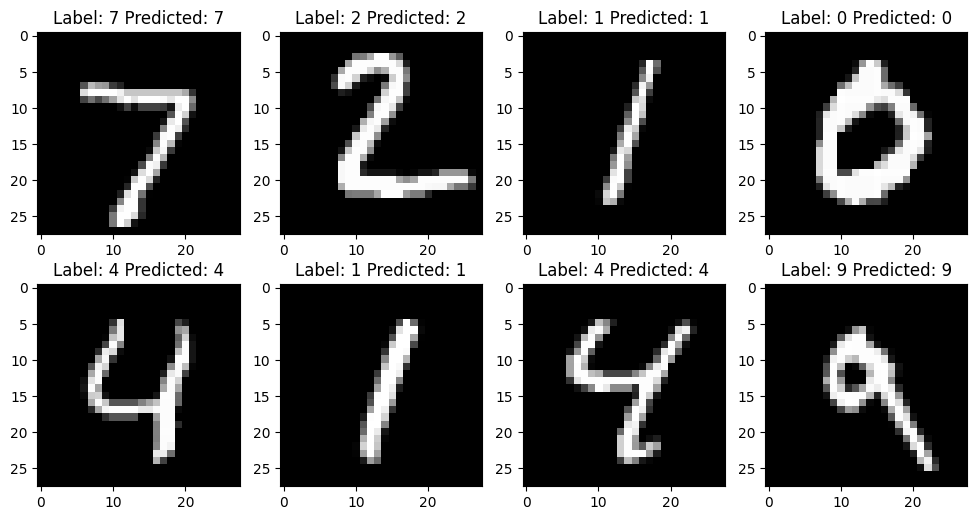

In [502]:
rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

for i, (instance, label) in enumerate(DataLoader(test_set, 1)):
    if i >= rows * cols:
        break

    ax = axes[i // cols, i % cols]
    ax.imshow(test_set.data[i], cmap="gray")
    ax.set_title(f"Label: {label.item()} Predicted: {model(instance).argmax(1).item()}")

plt.show()